## FFT Model demonstration
#### The following is a brief demonstration of the newly created FFT forecasting model. This model is especiall suited for data that is very seasonal. This is why I am using daily temperature data as an example input.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from u8timeseries import TimeSeries
from u8timeseries.models.fft import FFT
from u8timeseries.backtesting import simulate_forecast_ar
from u8timeseries.metrics import mape, overall_percentage_error, mase

### Read data and fill gaps (you can safely ignore this part, it was not made to look nice)

In [2]:
# create series
df = pd.read_csv('temps.csv')
dates = df['Daily minimum temperatures'].str.replace('^[^\d]*', '').astype(float)
dates.index = pd.to_datetime(df['Date'])

# find missing dates
delta = pd.date_range(start = '1981-01-01', end = '1990-12-31' ).difference(dates.index)

# add missing dates
delta_vals = pd.Series([np.mean(dates)] * len(delta))
delta_vals.index = delta
dates = dates.append(delta_vals)
dates = dates.sort_index()

### Constructing our TimeSeries instance and a train and validation set

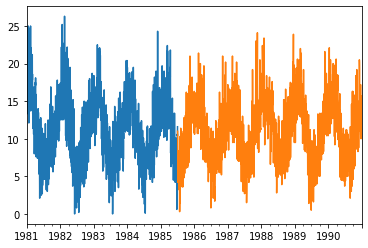

In [3]:
ts = TimeSeries.from_times_and_values(dates.index, dates)
train, val = ts.split_after(pd.Timestamp('19850701'))
train.plot()
val.plot()

### Default FFT model

In [4]:
model = FFT()
model.fit(train)
pred_val = model.predict(len(val))

[2020-04-29 16:51:18,389] INFO | u8timeseries.models.fft | fit function ran for 3 milliseconds


### Results:
#### The plot below shows us that a simple DFT with a random train-test split will most likely lead to bad results. Upon closer inspection we can see that the prediction (in green) simply repeats the training set (blue). This is the standard behavior of the DFT, and by itself it is quite useless, since repeating our training set could be done much more efficiently. Two improvements were made to this approach.

MAPE: 369701340014658.6


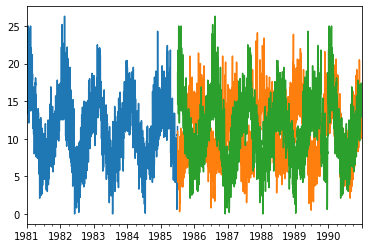

In [5]:
train.plot()
val.plot()
pred_val.plot()
print("MAPE:", mape(pred_val, val))

### Improvement 1: Crop the training set
#### The first improvement that was implemented consists of cropping the training set before feeding it to the FFT algorithm such that the first timestamp in the cropped series matches the first timestamp to be predicted in terms of seasonality, i.e. it has to have the same month, day, weekday or time of day. We can achieve this by passing the optional argument 'required_matches' to the FFT constructor. In this case we want to the first timestamp in the training set to match the day of the month and the month of the year of the first predicted timestamp.

In [6]:
model = FFT(required_matches={'month', 'day'})
model.fit(train)
pred_val = model.predict(len(val))

[2020-04-29 16:51:19,219] INFO | u8timeseries.models.fft | fit function ran for 25 milliseconds


### Results:
#### We can see that the results look like the seasonality of the predictions nicely aligns with the seasonality of the validation set. However, we are still just repeating the training set, including all of the noise. Looking at the error we can see that this is still a very bad forecast.

MAPE: 521378672076109.06


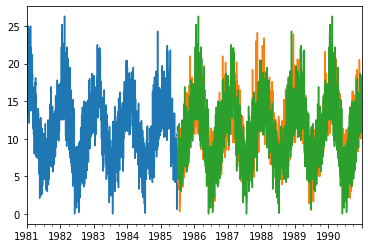

In [7]:
train.plot()
val.plot()
pred_val.plot()
print("MAPE:", mape(pred_val, val))

### Improvement 2: Filtering out low-amplitude waves
#### The decomposition of the DFT into the frequency domain allows us to selectively filter out waves with low amplitudes. This allows us to keep strong seasonal trends while discarding some noise. This is achieved in the FFT model by passing the optional argument 'filter_first_n'. This argument represents the total number of frequencies that will be kept. For instance, if a value of 20 is passed, only the 20 frequencies with the highest amplitudes will be utilized.

In [8]:
model = FFT(required_matches={'month', 'day'}, nr_freqs_to_keep=20)
model.fit(train)
pred_val = model.predict(len(val))

[2020-04-29 16:51:20,119] INFO | u8timeseries.models.fft | fit function ran for 24 milliseconds


### Results:
#### We get a signal that is less noisy. Depending on the data set, this might be a better forecast. Looking at the error metric, we can see that this model performs significantly better than the previous models.

MAPE: 23.29757564574581


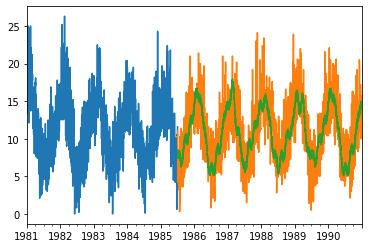

In [9]:
train.plot()
val.plot()
pred_val.plot()
print("MAPE:", mape(pred_val, val))

In [ ]:
historical_fcast = simulate_forecast_ar(ts, model, pd.Timestamp('19870105'), fcast_horizon_n=10, verbose=True)

In [ ]:
ts.drop_before(pd.Timestamp('1986')).plot()


historical_fcast.plot()

#### Let's try out a different data set that has a global upward trend

In [ ]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
ts_2 = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
train, val = ts_2.split_after(pd.Timestamp('19551201'))
train.plot()
val.plot()

In [ ]:
model = FFT(required_matches={'month', 'day'}, nr_freqs_to_keep=100)
model.fit(train)
pred_val = model.predict(len(val))

#### Clearly, our model fails completely at incorporating the upward trend

In [ ]:
train.plot()
val.plot()
pred_val.plot()

#### This problem can be solved by activating the 'detrend' option, which fits a polynomial to the data and subtracts it before moving on to DFT. When predicting, the trend is added again.

In [ ]:
model = FFT(required_matches={'month', 'day'}, nr_freqs_to_keep=100, trend=True)
model.fit(train)
pred_val = model.predict(len(val))

### Result:
#### We have a much better prediction now.

In [ ]:
train.plot()
val.plot()
pred_val.plot()